# Intro to PyStan

Stan is a computation engine for Bayesian model fitting. It relies on HMC to sample from the posterior distribution of the desired model.

Here are the detailed installation steps to set up Stan: https://pystan.readthedocs.io/en/latest/installation_beginner.html

For MacOS:
* install miniconda/anaconda
* install `xcode`
* open a terminal
* update your C-compiler: `conda install clang_osx-64 clangxx_osx-64 -c anaconda`
* create an environment "stan" or "pystan" or whatever you'd like to name it
* type `conda install numpy` to install numpy or replace numpy with the package you need to install
* install pystan `conda install -c conda-forge pystan`
    * Alternatively: `pip install pystan`
* Also install: `arviz`, `matplotlib`, `pandas`, `scipy`, `seaborn`, `statsmodels`, `pickle`, `scikit-learn`,`nb_conda`, and `nb_conda_kernels`


In [1]:
import pystan
import pickle
import numpy as np
import arviz as az
import pandas as pd
import seaborn as sns
import statsmodels.api as statmod
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 

### Toy example - Estimate $\theta$ from Bernoulli observations

Recall that $y \sim \text{Bernoulli}(\theta)$ is equivalent to
$$
P(Y=y|\theta) = \theta^{y} (1-\theta)^{1-y},\\ \text{where } Y \in \{0,1\}, \theta \in [0,1]
$$

Imagine we have an arbitrary coin and we would like to determine whether it is fair ($\theta$ = 50%) or not. For this problem, we observe a sample of Y's (1 indicates heads, while 0 indicates tails).

We experiment by flipping this coin K number of times. We would like to estimate $\theta$, i.e., the probability that we obtain heads for a given toss.

If we tackle this problem from the frequentist perspective, we can easily devise the maximum likelihood estimator for $\theta$ as 
$$\hat{\theta}_{ML} = \sum_{i}^{K}\frac{y_{i}}{K},$$ where $K$ corresponds to the number of trials/observations in our experiment.

Say we flip the coin **4** times and, by struck of luck (or lack thereof), we observe **all** tails. Then, 

$$\hat{\theta}_{ML} = \sum_{i}^{4}\frac{y_{i}}{4}=0$$

which is quite extreme, for, having two sides, there is **SOME** probability that we can observe heads in the next trial.

#### Applied Bayesian inference

We can adopt a more 'scientific' approach by expressing our prior belief about this coin. Say I believe the coin is most likely to be fair, but I believe there to be a (possibly smaller) chance that it is not.

Then I can establish the following prior probability on $\theta$:
$$
\theta \sim \text{beta}(5,5)
$$

This prior makes sense because $\forall \alpha, \beta \in \mathcal{R}^+, \text{ beta}(\alpha,\beta) \in [0,1]$, namely, $\theta$ is a probability and **cannot** be less than 0 or greater than 1.

Let's visualize this prior by sampling from it:

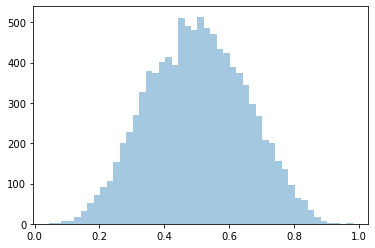

In [3]:
sns.distplot(np.random.beta(5, 5, size=10000),kde=False)

In [4]:
# bernoulli model
model_code = """
    data {
      int<lower=0> N;
      int<lower=0,upper=1> y[N];
    }
    parameters {
      real<lower=0,upper=1> theta;
    }
    model {
      theta ~ beta(5, 5);
      for (n in 1:N)
          y[n] ~ bernoulli(theta);
    }
    """
data = dict(N=4, y=[0, 0, 0, 0])
model = pystan.StanModel(model_code=model_code)
fit = model.sampling(data=data)

la = fit.extract(permuted=True)  # return a dictionary of arrays

# with open('model.pkl', 'wb') as f:
#     pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

# # load it at some future point
# with open('model.pkl', 'rb') as f:
#     model = pickle.load(f)

# # run with different data
# fit = model.sampling(data=dict(N=5, y=[1, 1, 0, 1, 0]))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d3835c4370ff5e66f1e88bd3eac647ff NOW.


In [5]:
print(fit.stansummary())

Inference for Stan model: anon_model_d3835c4370ff5e66f1e88bd3eac647ff.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta   0.36  3.2e-3   0.12   0.14   0.27   0.35   0.44   0.61   1475    1.0
lp__   -9.63    0.02   0.68 -11.58   -9.8  -9.36  -9.18  -9.13   1758    1.0

Samples were drawn using NUTS at Thu Nov 28 15:02:53 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [6]:
fit_post = model.sampling(data=dict(N=5, y=[1, 1, 0, 1, 0]))
print(fit_post.stansummary())

Inference for Stan model: anon_model_d3835c4370ff5e66f1e88bd3eac647ff.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta   0.53  3.2e-3   0.12   0.29   0.45   0.53   0.62   0.77   1503    1.0
lp__  -10.87    0.02   0.73 -12.89 -11.03 -10.59 -10.41 -10.36   1584    1.0

Samples were drawn using NUTS at Thu Nov 28 15:02:53 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## Car MPG Problem

Predict/estimate `mpg` based on available features:
* `weight`
* `year`
* `cylinders`
* `hp`
* `acceleration`
* `displacement`
* `origin`

In [115]:
Image(url= "https://external-preview.redd.it/fCEkl9G2WE3sw6VHYU8TM1J5K7zgmvECNWv__srdML0.jpg?auto=webp&s=5b8973a18dea7d517229b6dca1123c354bbe7603")

Let's start with the regression equation for it shall inform how we think of our models, both as a maximum-likelihood curve-fitting problem and Bayesian generative modelling problem:

$$
Y = X\beta + \epsilon \\
\text{where } \epsilon \sim \text{MVN}(0,\Sigma)
$$

Note that the only random quantity in our equation above is $\epsilon$.

In [2]:
# Load the data
cars_data = pd.read_csv("~/Desktop/nerd/stan/cars.csv")
print(cars_data.shape)
cars_data.head()

(392, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,American,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,American,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,American,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,American,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,American,ford torino


### EDA

In [3]:
for col_name in cars_data.columns[1:]:
    print(cars_data[col_name].value_counts().head())

4    199
8    103
6     83
3      4
5      3
Name: cylinders, dtype: int64
97.0     21
350.0    18
250.0    17
98.0     17
318.0    17
Name: displacement, dtype: int64
150    22
90     20
88     19
110    18
100    17
Name: horsepower, dtype: int64
1985    4
2130    4
2125    3
2945    3
2720    3
Name: weight, dtype: int64
14.5    23
15.5    21
16.0    16
14.0    16
13.5    15
Name: acceleration, dtype: int64
73    40
78    36
76    34
82    30
75    30
Name: year, dtype: int64
American    245
Japanese     79
European     68
Name: origin, dtype: int64
amc matador           5
ford pinto            5
toyota corolla        5
ford maverick         4
chevrolet chevette    4
Name: name, dtype: int64


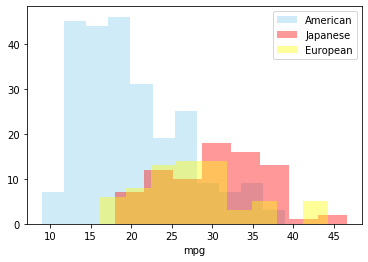

In [4]:
sns.distplot(cars_data[cars_data['origin']=='American']['mpg'],color="skyblue", label="American",kde=False)
sns.distplot(cars_data[cars_data['origin']=='Japanese']['mpg'],color="red", label="Japanese",kde=False)
sns.distplot(cars_data[cars_data['origin']=='European']['mpg'],color="yellow", label="European",kde=False)
plt.legend()


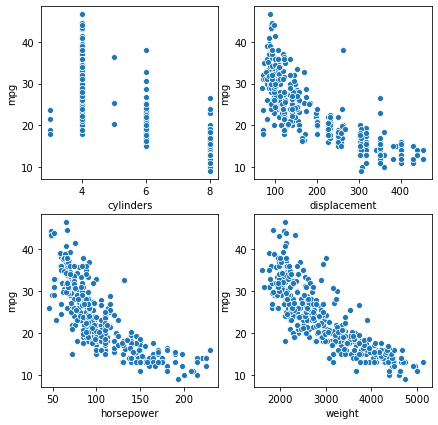

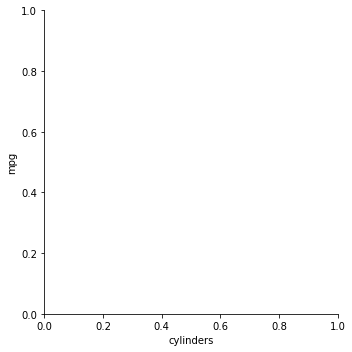

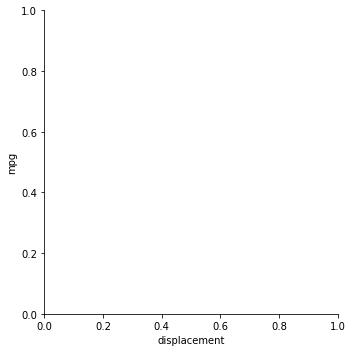

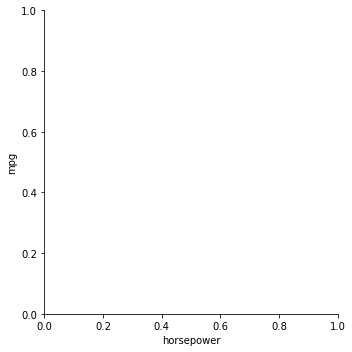

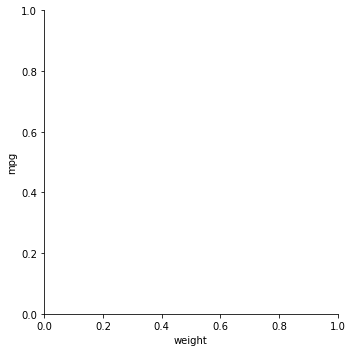

In [5]:
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=False)
sns.relplot(x="cylinders", y="mpg", data=cars_data, ax=axes[0, 0]);
sns.relplot(x="displacement", y="mpg", data=cars_data, ax=axes[0, 1]);
sns.relplot(x="horsepower", y="mpg", data=cars_data, ax=axes[1, 0]);
sns.relplot(x="weight", y="mpg", data=cars_data, ax=axes[1, 1]);

### Maximum Likelihood OLS Regression

In [6]:
cars_data.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower        int64
weight            int64
acceleration    float64
year              int64
origin           object
name             object
dtype: object

In [24]:
from numpy import random
from sklearn import preprocessing, metrics, linear_model
#metrics.mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

random.seed(12345)


cars_data_vars = cars_data.columns.values[:-1].tolist()

y = cars_data['mpg']
X = cars_data.loc[:, cars_data.columns != 'mpg']
X = X.loc[:, X.columns != 'name']
X = pd.get_dummies(X, prefix_sep='_', drop_first=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

X_train.head()

,cylinders,displacement,horsepower,weight,acceleration,year,origin_American,origin_European,origin_Japanese
60,4,122.0,86,2226,16.5,72,1,0,0
15,6,198.0,95,2833,15.5,70,1,0,0
145,4,90.0,75,2108,15.5,74,0,1,0
276,4,89.0,71,1990,14.9,78,0,1,0
5,8,429.0,198,4341,10.0,70,1,0,0


In [25]:
# Fit and summarize OLS model
X_train['const'] = 1; X_test['const'] = 1
mod1 = statmod.OLS(y_train, X_train, prepend=False)
res = mod1.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     185.8
Date:                Thu, 28 Nov 2019   Prob (F-statistic):          3.62e-116
Time:                        15:12:48   Log-Likelihood:                -867.88
No. Observations:                 333   AIC:                             1754.
Df Residuals:                     324   BIC:                             1788.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
cylinders          -0.4860      0.354     

/opt/miniconda3/envs/pystan/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [37]:
y_train_freq = res.predict(X_train)
y_train_freq.head()

60     24.158664
15     18.969269
145    28.110046
276    31.896397
5      10.882384
dtype: float64

In [36]:
y_test_freq = res.predict(X_test)
y_test_freq.head()

144    25.439595
280    25.246113
68     10.611716
372    32.004156
328    33.100909
dtype: float64

Freq Train MSE: 10.747087997216699


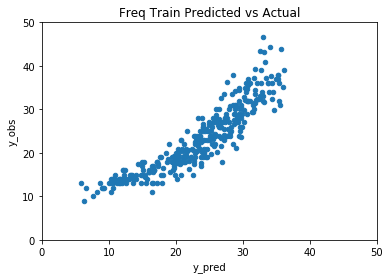

In [38]:
print('Freq Train MSE:', metrics.mean_squared_error(y_train, y_train_freq))
dff = pd.DataFrame({'y_pred':y_train_freq, 'y_obs':y_train})
dff.plot('y_pred', 'y_obs', kind='scatter',ylim=(0,50),xlim=(0, 50),title="Freq Train Predicted vs Actual")

Freq Test MSE: 10.558052934001227


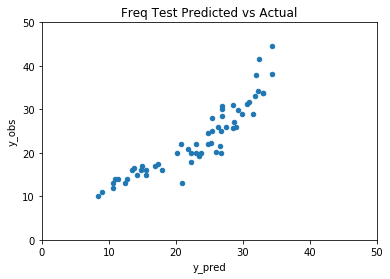

In [41]:
print('Freq Test MSE:', metrics.mean_squared_error(y_test, y_test_freq))
dff = pd.DataFrame({'y_pred':y_test_freq, 'y_obs':y_test})
dff.plot('y_pred', 'y_obs', kind='scatter',ylim=(0,50),xlim=(0, 50),title="Freq Test Predicted vs Actual")

### Bayesian OLS Regression

Recall the expression to evaluate the Bayesian posterior of the model parameters:

$$
P(\theta|D) \propto P(D|\theta)P(\theta)
$$

Once we obtain an approximation of the posterior $P(\theta|D)$, we can actually compute a predictive posterior to fit an unseen/test vector of data points $X_{\text{new}}$:

$$
P(X_{new}|D_{old}) = \int{P(X_{new}|\theta,D_{old})P(\theta|D_{old})}\,d\theta
$$

In [116]:
X_train.head()

,cylinders,displacement,horsepower,weight,acceleration,year,origin_American,origin_European,origin_Japanese
60,4,122.0,86,2226,16.5,72,1,0,0
15,6,198.0,95,2833,15.5,70,1,0,0
145,4,90.0,75,2108,15.5,74,0,1,0
276,4,89.0,71,1990,14.9,78,0,1,0
5,8,429.0,198,4341,10.0,70,1,0,0


In [93]:
# Succint matrix notation

cars_code = """
data {
    int<lower=1> N; // number of training samples
    int<lower=0> K; // number of predictors
    matrix[N, K] x; // matrix of predictors
    vector[N] y_obs; // observed/training mpg
    
    int<lower=1> N_new;
    matrix[N_new, K] x_new;
}
parameters {
    real alpha;
    vector[K] beta;
    //vector[K] tau;
    real<lower=0> sigma;
    
    vector[N_new] y_new;
}
transformed parameters {
    vector[N] theta;
    theta = alpha + x * beta;
}
model {
    sigma ~ normal(0, 1);
    //alpha ~ normal(10, .1);
    //beta ~ multi_normal(rep_vector(0, K), diag_matrix(tau));
    beta ~ multi_normal(rep_vector(0, K), diag_matrix(rep_vector(1, K)));
    y_obs ~ normal(theta, sigma);
    
    y_new ~ normal(alpha + x_new * beta, sigma); // prediction model
}
"""

cars_dat = {'N': X_train.shape[0],
            'N_new': X_test.shape[0],
            'K': X_train.shape[1],
            'y_obs': y_train.values.tolist(),
            'x': np.array(X_train),
            'x_new': np.array(X_test)}


sm = pystan.StanModel(model_code=cars_code)
fit = sm.sampling(data=cars_dat, iter=1000, chains=8)

# Save fitted model!
with open('bayes-cars.pkl', 'wb') as f:
    pickle.dump(sm, f, protocol=pickle.HIGHEST_PROTOCOL)
    
# Load it
with open('bayes-cars.pkl', 'rb') as f:
    sm = pickle.load(f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecd324ca9c9a63c14b255d51c4d42cb4 NOW.


In [94]:
la = fit.extract(permuted=True)
print(fit.stansummary())

Inference for Stan model: anon_model_ecd324ca9c9a63c14b255d51c4d42cb4.
8 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha      -14.63     0.1   4.88 -24.21 -17.93 -14.69  -11.4   -4.9   2484    1.0
beta[1]     -0.42  4.8e-3   0.32  -1.03  -0.64  -0.43   -0.2   0.22   4552    1.0
beta[2]      0.02  1.2e-4 8.0e-3 5.6e-3   0.02   0.02   0.03   0.04   4719    1.0
beta[3]   -9.8e-3  2.6e-4   0.01  -0.04  -0.02-9.7e-3 5.7e-4   0.02   3320    1.0
beta[4]   -7.1e-3  1.0e-5 6.9e-4-8.5e-3-7.6e-3-7.1e-3-6.6e-3-5.7e-3   4509    1.0
beta[5]      0.14  1.7e-3   0.11  -0.06   0.07   0.15   0.22   0.35   3935    1.0
beta[6]      0.75  9.9e-4   0.05   0.64   0.71   0.75   0.78   0.85   3105    1.0
beta[7]     -1.38    0.01   0.65  -2.64  -1.81  -1.38  -0.95  -0.08   3122    1.0
beta[8]      0.65    0.01   0.64   -0.6   0.21   0.65    1.1   1.91   3058 

In [142]:
post_data = az.convert_to_dataset(fit)

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'year', 'origin_American', 'origin_European', 'origin_Japanese'],
      dtype='object')


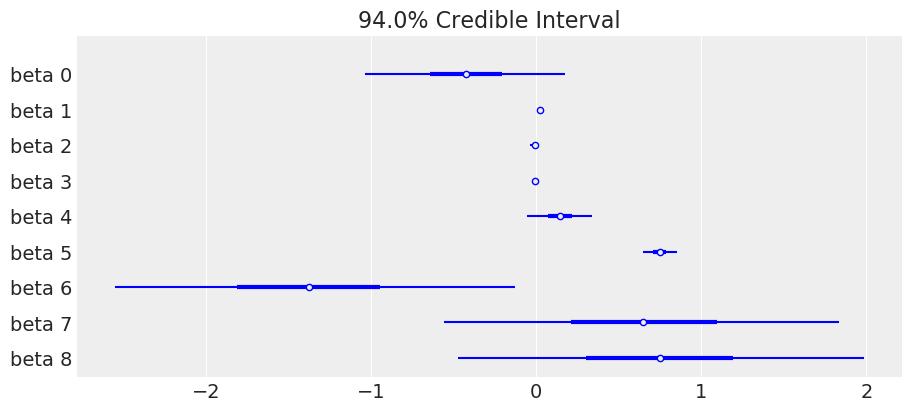

In [162]:
# Let's examine the posterior distribution of our model parameters
print(X_train.columns)
axes = az.plot_forest(
    post_data,
    kind="forestplot",
    var_names= ["beta"],
    combined=True,
    ridgeplot_overlap=1.5,
    colors="blue",
    figsize=(9, 4),
)

Print out some MC diagnostic plots (trace/mixing plots, etc)

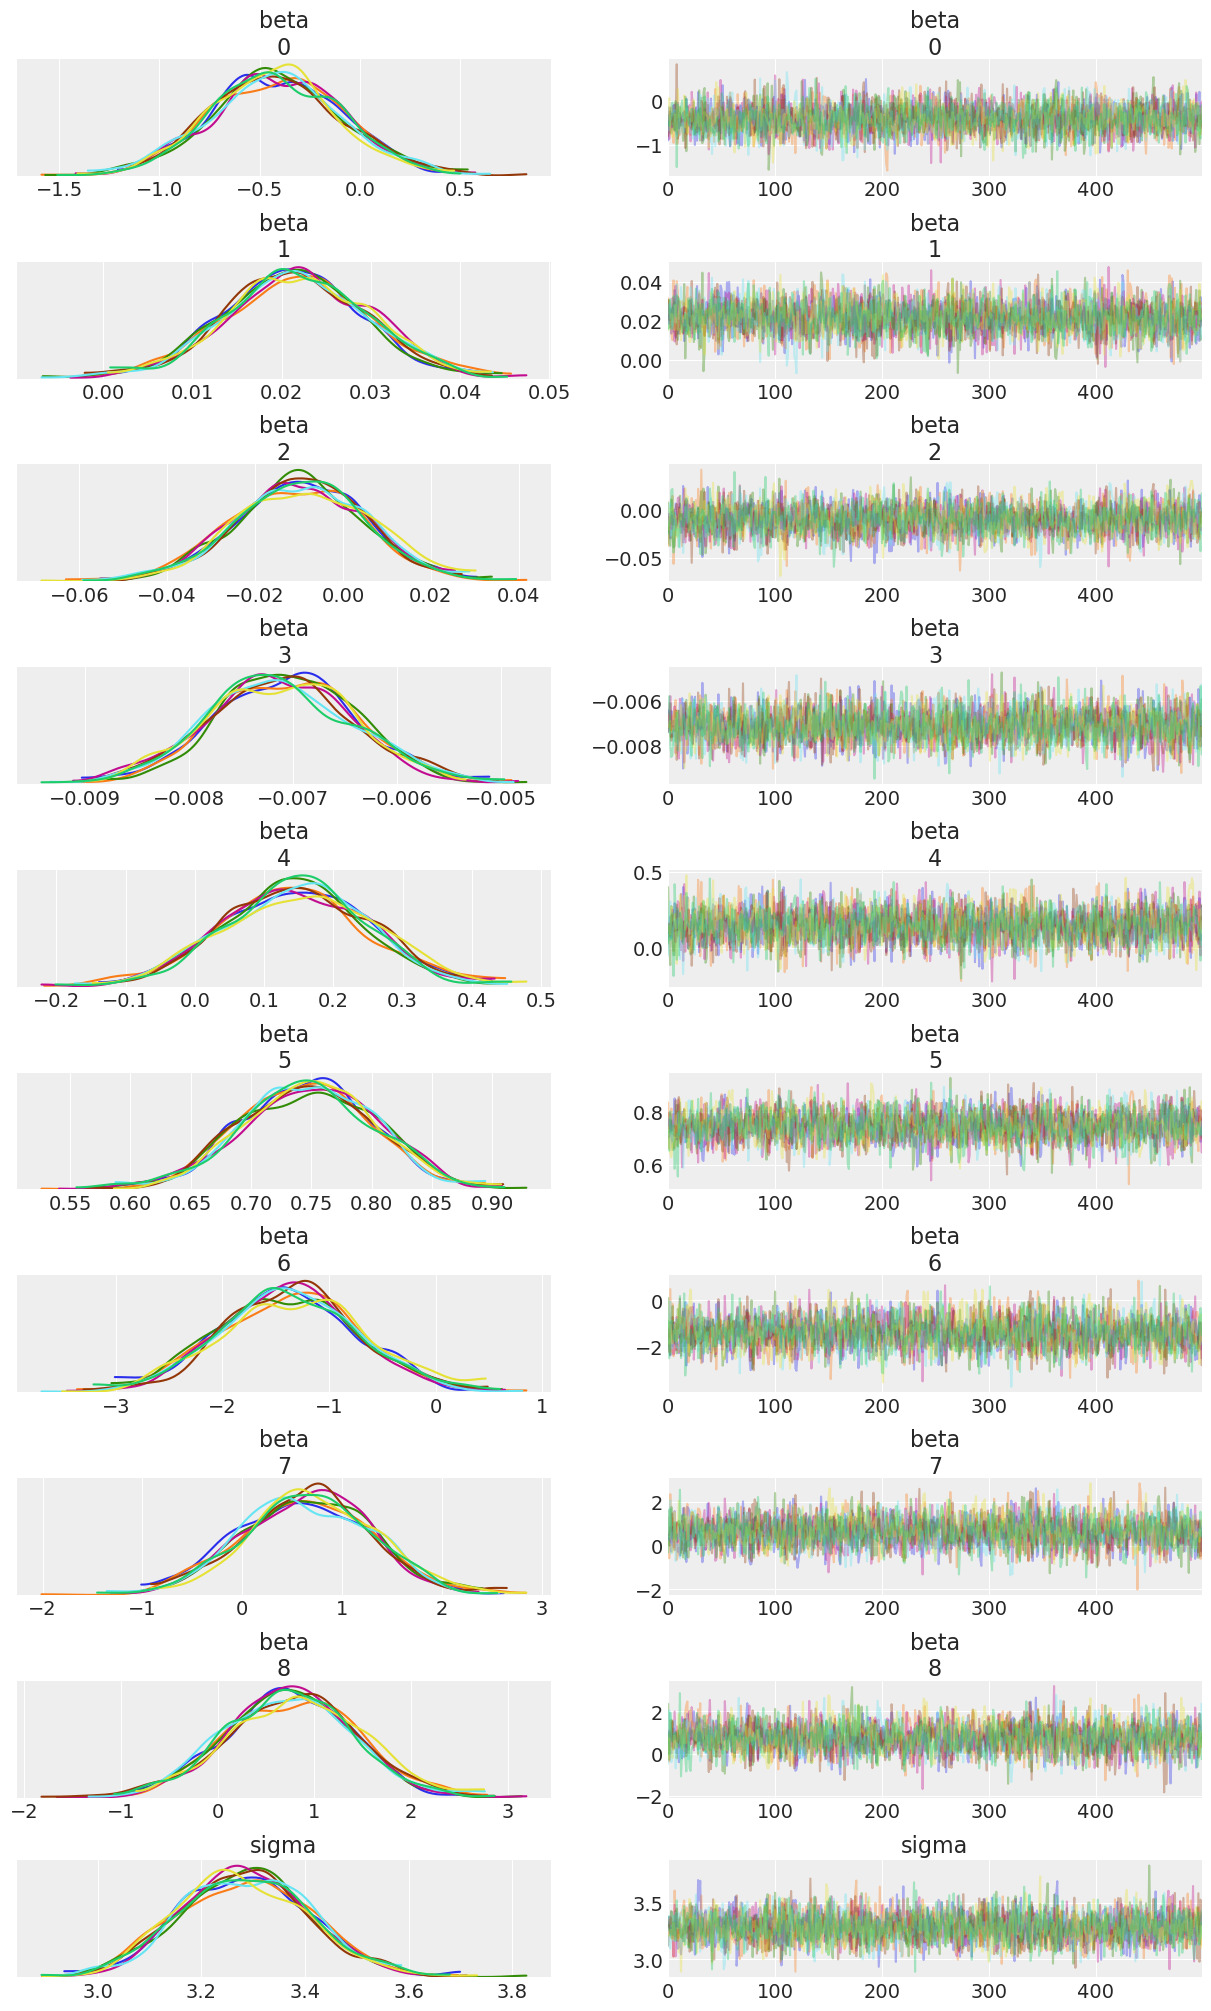

In [114]:
ax = az.plot_trace(fit, var_names=["beta","sigma"])
# Great mixing: The thicker the better


Bayes Train MSE: 10.76581266332438


/opt/miniconda3/envs/pystan/lib/python3.7/site-packages/seaborn/axisgrid.py:1741: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


Text(0.5, 0.98, 'Bayes Train Pred vs Obs')

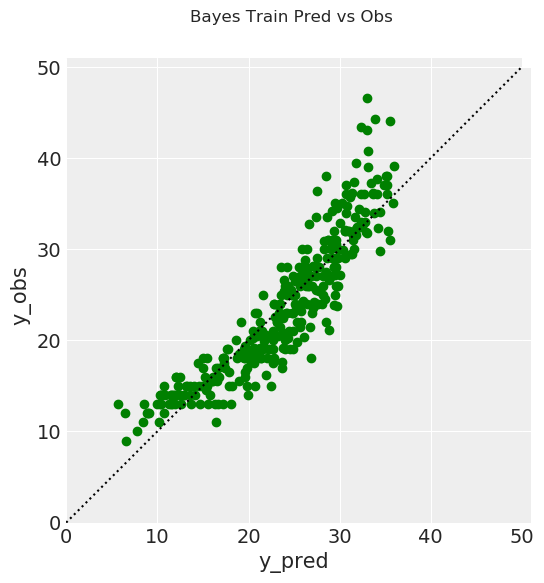

In [85]:
print('Bayes Train MSE:', metrics.mean_squared_error(y_train.values, fit['theta'].mean(0)))
dff = pd.DataFrame({'y_pred':fit['theta'].mean(0), 'y_obs':y_train.values})
grid = sns.JointGrid(dff.y_pred, dff.y_obs, space=0, height=6, ratio=50,
                    xlim=(0,50), ylim=(0,50))
grid.plot_joint(plt.scatter, color="g")
x0, x1 = grid.ax_joint.get_xlim()
y0, y1 = grid.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
grid.ax_joint.plot(lims, lims, ':k')
plt.subplots_adjust(top=0.9)
grid.fig.suptitle('Bayes Train Pred vs Obs')

Bayes Test MSE: 10.723590400488478


/opt/miniconda3/envs/pystan/lib/python3.7/site-packages/seaborn/axisgrid.py:1741: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


Text(0.5, 0.98, 'Bayes Test Predicted vs Obs')

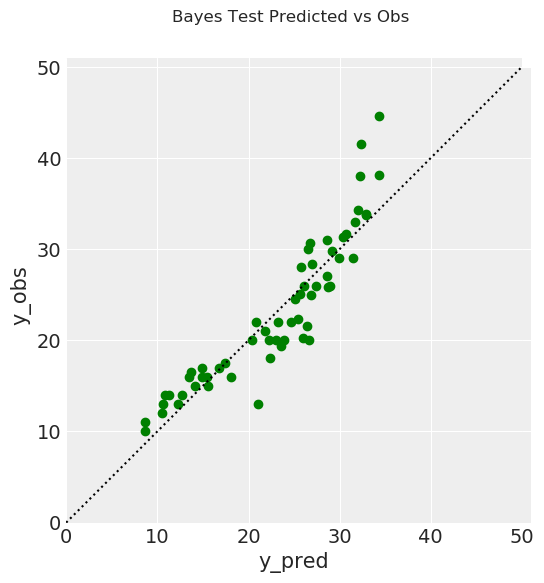

In [86]:
print('Bayes Test MSE:', metrics.mean_squared_error(y_test, la['y_new'].mean(0)))
dff = pd.DataFrame({'y_pred':la['y_new'].mean(0), 'y_obs':y_test})
grid = sns.JointGrid(dff.y_pred, dff.y_obs, space=0, height=6, ratio=50,
                    xlim=(0,50), ylim=(0,50))
grid.plot_joint(plt.scatter, color="g")
x0, x1 = grid.ax_joint.get_xlim()
y0, y1 = grid.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
grid.ax_joint.plot(lims, lims, ':k')  

plt.subplots_adjust(top=0.9)
grid.fig.suptitle('Bayes Test Predicted vs Obs')

Visualize the value of the prediction as we vary some model inputs, along with the prediction 95% confidence bands:

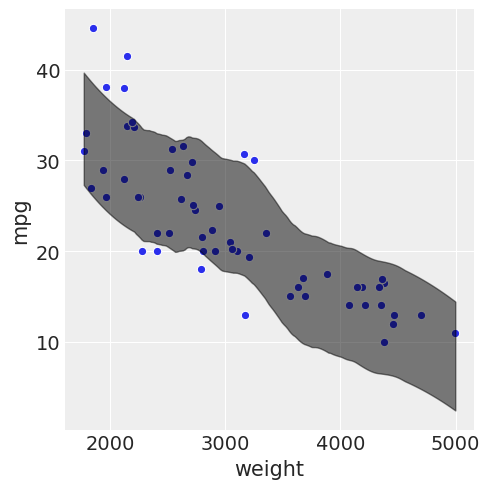

In [61]:
import matplotlib.pyplot as plt
import weakref
az.style.use("arviz-darkgrid")

sns.relplot(x="weight", y="mpg",
            data=pd.DataFrame({'weight':X_test['weight'],'mpg':y_test}))
az.plot_hpd(X_test['weight'], la['y_new'], color="k", plot_kwargs={"ls": "--"})

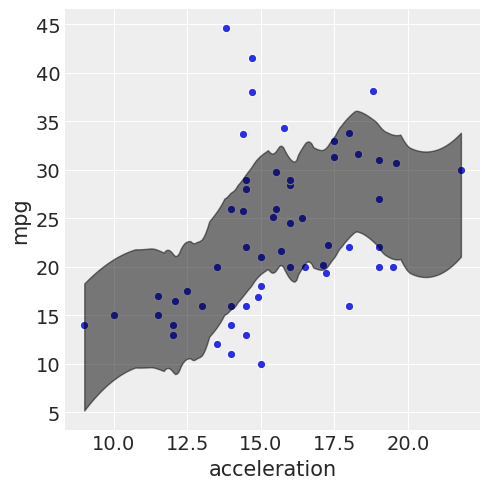

In [64]:
sns.relplot(x="acceleration", y="mpg",
            data=pd.DataFrame({'acceleration':X_test['acceleration'],'mpg':y_test}))
az.plot_hpd(X_test['acceleration'], la['y_new'], color="k", plot_kwargs={"ls": "--"})